In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from cmocean import cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas7/grid.nc')

In [3]:
def calc_stats(x, y):
    stats = {}
    MSE = np.nanmean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.nanmean(y) - np.nanmean(x)
    stats['WSS'] = 1 - MSE / np.nanmean((abs(y - np.nanmean(x)) + abs(x - np.nanmean(x)))**2)
    
    return stats

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.2f} {units}\nbias = {stats['bias']:.2f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0, 0.8, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c


In [4]:
ctd2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2013.p')
ctd2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2014.p')
ctd2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2015.p')
ctd2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2016.p')
ctd2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2017.p')
ctd2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2018.p')
ctd2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2019.p')


In [5]:
bot2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2013.p')
bot2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2014.p')
bot2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2015.p')
bot2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2016.p')
bot2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2017.p')
bot2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2018.p')
bot2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2019.p')


In [26]:
obs = pd.concat([bot2013['obs'], bot2014['obs'], bot2015['obs'], bot2016['obs'], bot2017['obs'], bot2018['obs'], bot2019['obs']], ignore_index=True)
obs.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
obs = pd.concat([obs,ctd2013['obs'], ctd2014['obs'], ctd2015['obs'], ctd2016['obs'], ctd2017['obs'], ctd2018['obs'], ctd2019['obs']], ignore_index=True)
obs.head()

,cid,lon,lat,time,z,SA,CT,DO (uM),NO3 (uM),Chl (mg m-3),name,cruise,source,NO2 (uM),NH4 (uM),PO4 (uM),SiO4 (uM),TA (uM),DIC (uM)
0,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-4.858567,29.526436,8.481087,217.480499,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-25.084826,29.931217,8.744595,194.705338,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-49.770050,30.161832,8.232655,199.617615,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-99.627083,31.185733,9.074455,7.145150,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-148.778397,31.455940,9.045912,5.805434,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# remove all unreasonable DO values, based on calculated max DO
obs.loc[obs['DO (uM)'] > 475, 'DO (uM)'] = pd.NA

# remove negative NO3 and Chl
obs.loc[obs['NO3 (uM)'] < 0, 'NO3 (uM)'] = pd.NA
obs.loc[obs['Chl (mg m-3)'] < 0, 'Chl (mg m-3)'] = pd.NA


Text(0, 0.5, 'Monthly count')

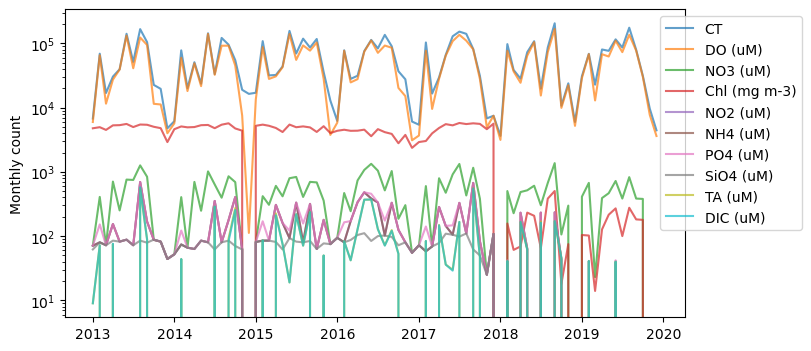

In [8]:
# lets see how the count of data changes with time, seperated by what was measured
# Extract both month and year from the 'time' column
obs['year_month'] = obs['time'].dt.to_period('M')  # This creates a Period object 'YYYY-MM'
obs['year_month'] = obs['year_month'].dt.to_timestamp()

# Columns to count non-NaN entries
columns_to_count = [
    'SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 
    'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)'
]

# Group by 'year_month' and count non-NaN entries for each column
monthly_counts = obs.groupby('year_month')[columns_to_count].count()

# plot
fig, ax = plt.subplots(1,1,figsize=[8,4])

for var in monthly_counts.columns[1:]:
    ax.plot(monthly_counts.index, monthly_counts[var], label=var,alpha=0.7)

ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.2, 1.0))
ax.set_ylabel('Monthly count')


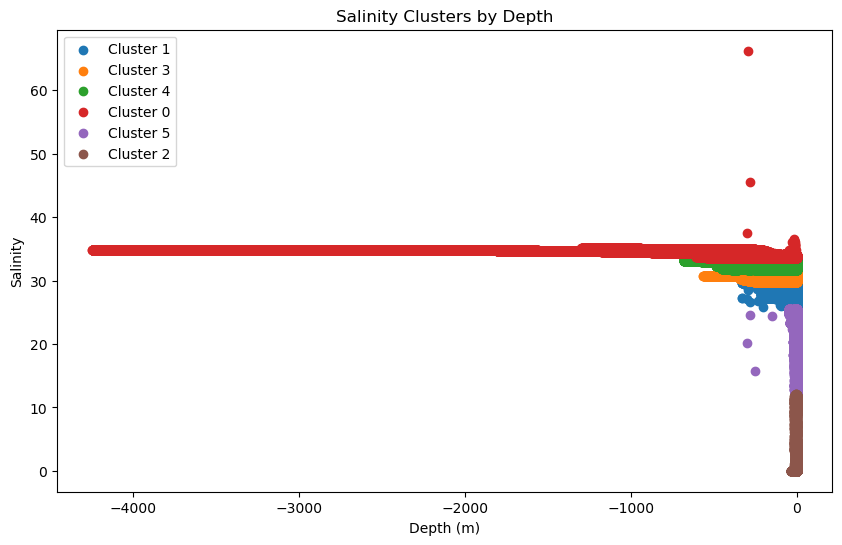

In [11]:
from sklearn.cluster import KMeans

# Drop rows with NaN values in the 'salinity' column
df_clean = obs.dropna(subset=['SA'])

# Selecting the property to cluster
X = df_clean[['SA']].values

# Applying K-means clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

# Assign the cluster labels back to the DataFrame
df_clean['Cluster'] = kmeans.labels_

# Plotting clusters vs. depth
plt.figure(figsize=(4, 2))
for cluster in df_clean['Cluster'].unique():
    cluster_data = df_clean[df_clean['Cluster'] == cluster]
    plt.scatter(cluster_data['z'], cluster_data['SA'], label=f'Cluster {cluster}')

plt.xlabel('Depth (m)')
plt.ylabel('Salinity')
plt.title('Salinity Clusters by Depth')
plt.legend()
plt.show()


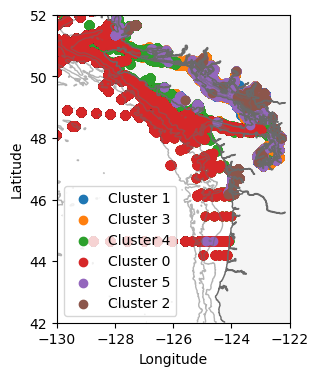

In [13]:
# plot by tracer (except SA and CT)
fig, ax = plt.subplots(1,1,figsize=(3, 4))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
for cluster in df_clean['Cluster'].unique():
    cluster_data = df_clean[df_clean['Cluster'] == cluster]
    ax.scatter(cluster_data['lon'], cluster_data['lat'], label=f'Cluster {cluster}')

ax.legend()

## remove salish sea points (too many of the clusters delineating within there)

In [43]:
ny = 49.2
sy = 47.4
d = 2000

# from evaluations code where i separate into regions
ind = np.where((obs.lon > np.sqrt((1-(((obs.lat-42)**2)/(10**2)))*(7**2))-130) & (obs.lat < 51)) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [66]:
def cluster_plot(key):
    # Drop rows with NaN values in the 'salinity' column
    df_clean = obs.dropna(subset=[key])

    # Selecting the property to cluster
    X = df_clean[[key]].values

    # Applying K-means clustering
    kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

    # Assign the cluster labels back to the DataFrame
    df_clean['Cluster'] = kmeans.labels_

    # Plotting clusters
    plt.figure(figsize=(9,4)) 
    ax0 = plt.subplot(131)
    ax1 = plt.subplot(132)
    ax2 = plt.subplot(133, projection='3d')

    for cluster in df_clean['Cluster'].unique():
        cluster_data = df_clean[df_clean['Cluster'] == cluster]
        ax0.scatter(cluster_data[key], cluster_data['z'], alpha=0.2, s=2, label=f'Cluster {cluster}')
        ax1.scatter(cluster_data['lon'], cluster_data['lat'], alpha=0.2, s=3, label=f'Cluster {cluster}')
        ax2.scatter(cluster_data['lon'], cluster_data['lat'], cluster_data['z'], zdir='z', s=2, alpha=0.2, depthshade=True)

    ax0.set_ylabel('Depth (m)')
    ax0.set_xlabel(key)
    ax0.set_title(key+' Clusters')
    ax0.legend()
    ax0.set_ylim([-4000,0])


    ax1.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
    ax1.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
    ax1.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
    ax1.set_ylabel('Latitude')
    ax1.set_xlabel('Longitude')
    ax1.set_ylim([42,52])
    ax1.set_xlim([-130,-122])

    plt.tight_layout()

    return df_clean[['lon','lat','z',key,'Cluster']]

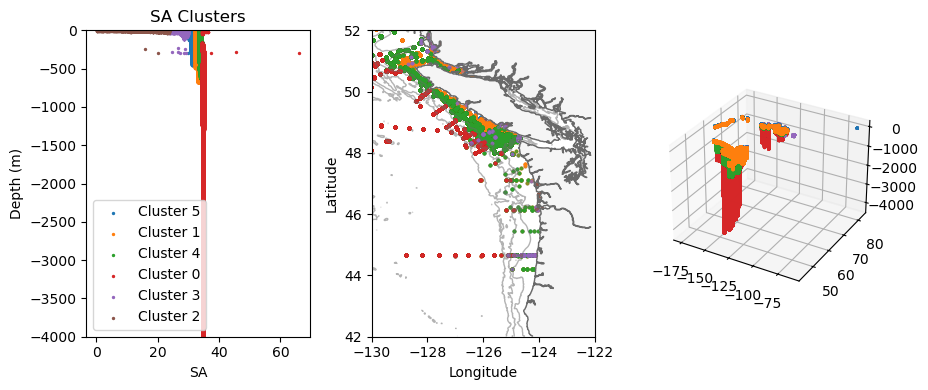

In [64]:
SAcluster = cluster_plot('SA')

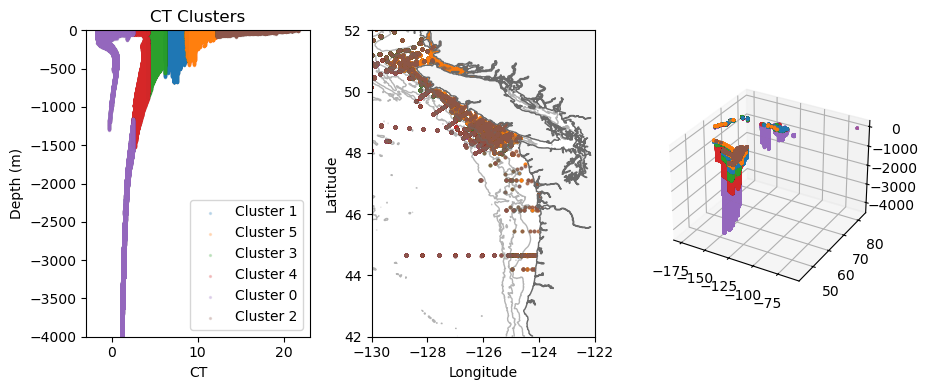

In [67]:
CTcluster = cluster_plot('CT')

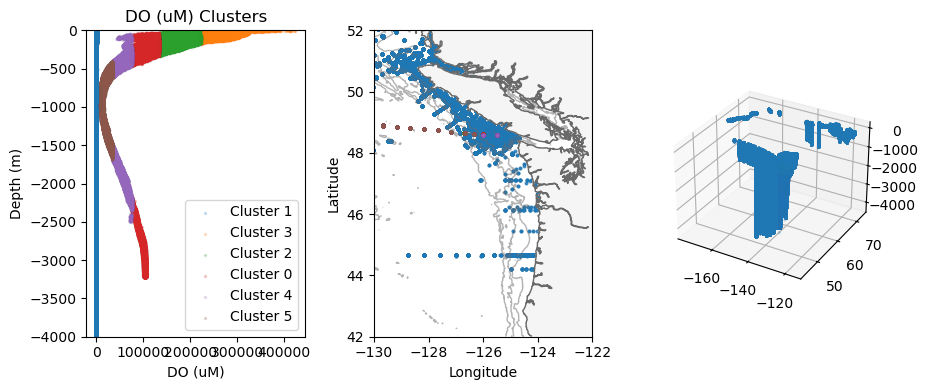

In [68]:
DOcluster = cluster_plot('DO (uM)')

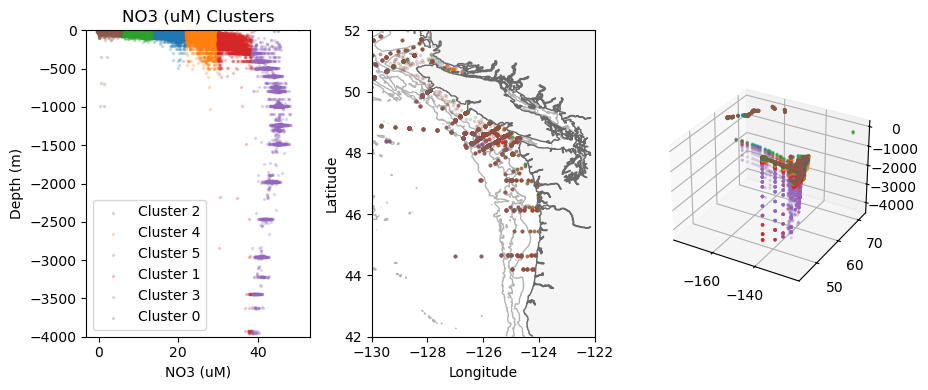

In [69]:
NO3cluster = cluster_plot('NO3 (uM)')

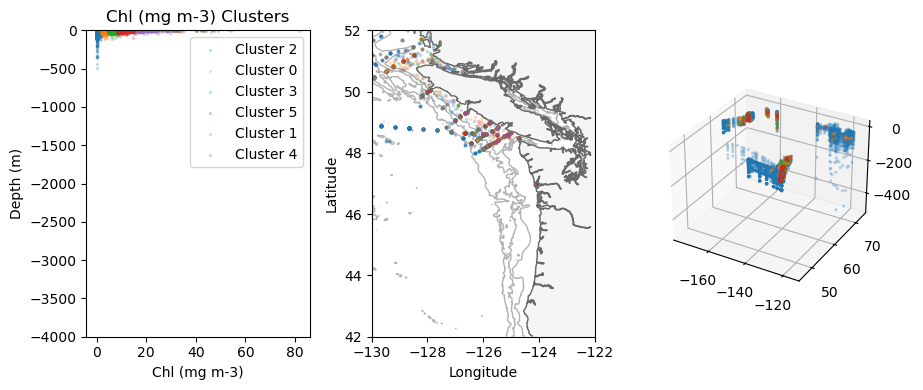

In [70]:
######thehjrwjrywjy5tjgggggtrhjrtyhjrtyhjrty

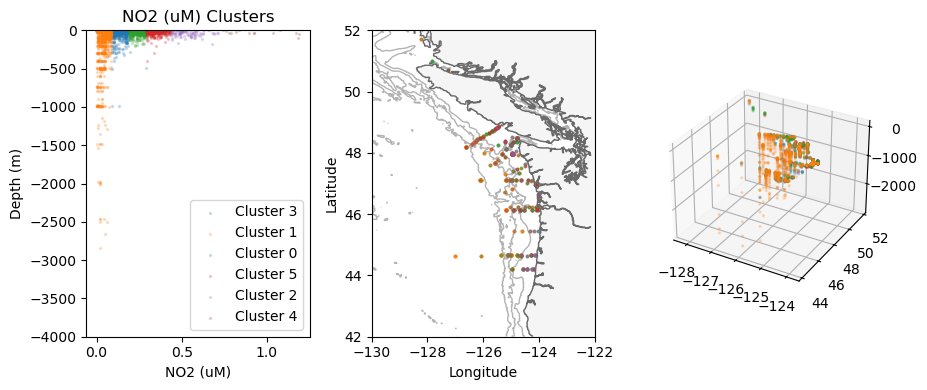

In [71]:
NO2cluster = cluster_plot('NO2 (uM)')

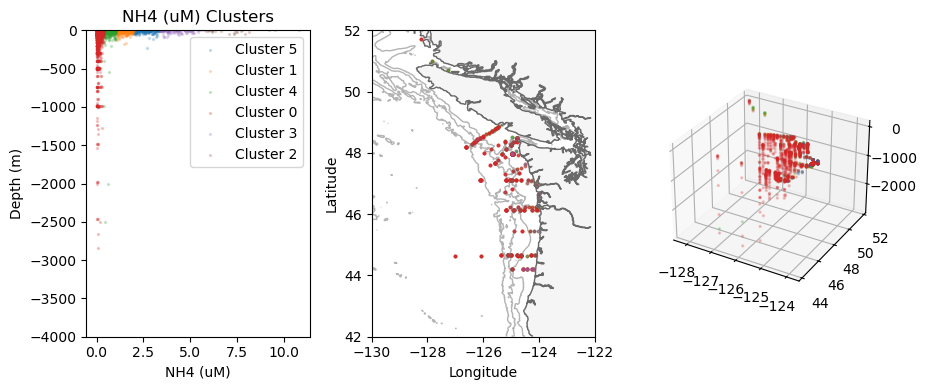

In [72]:
NH4cluster = cluster_plot('NH4 (uM)')

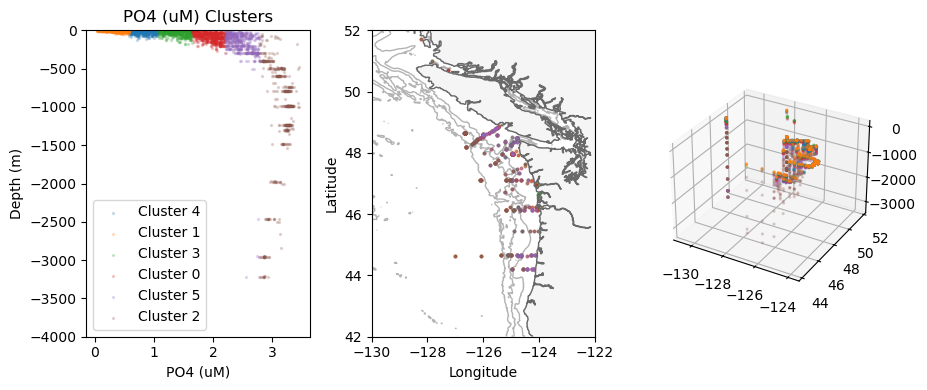

In [73]:
PO4cluster = cluster_plot('PO4 (uM)')

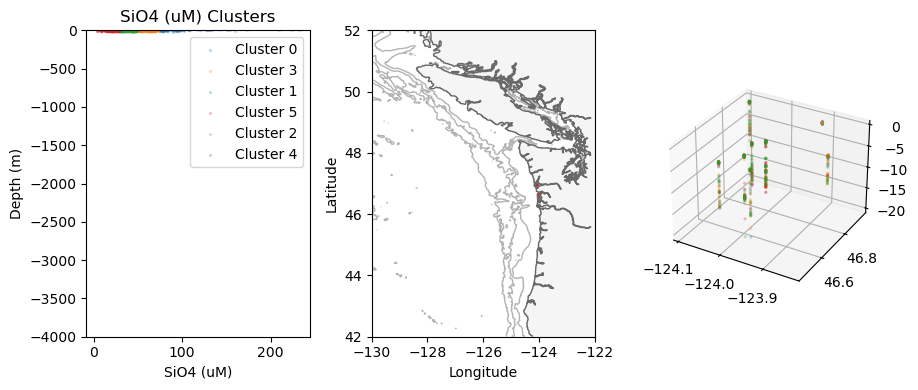

In [74]:
SiO4cluster = cluster_plot('SiO4 (uM)')

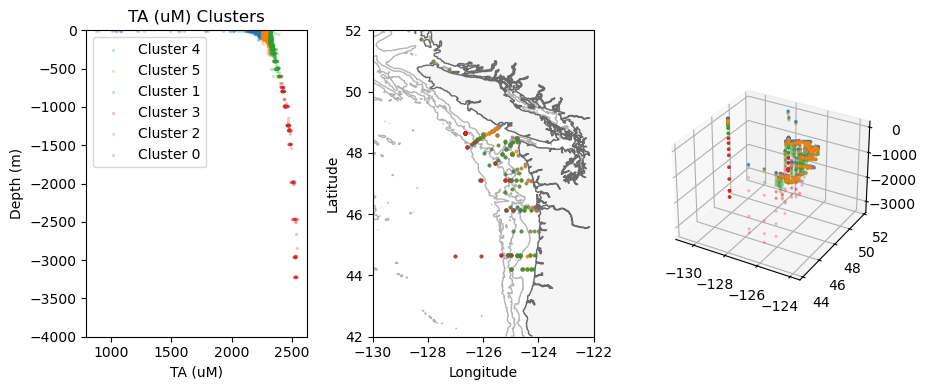

In [75]:
TAcluster = cluster_plot('TA (uM)')

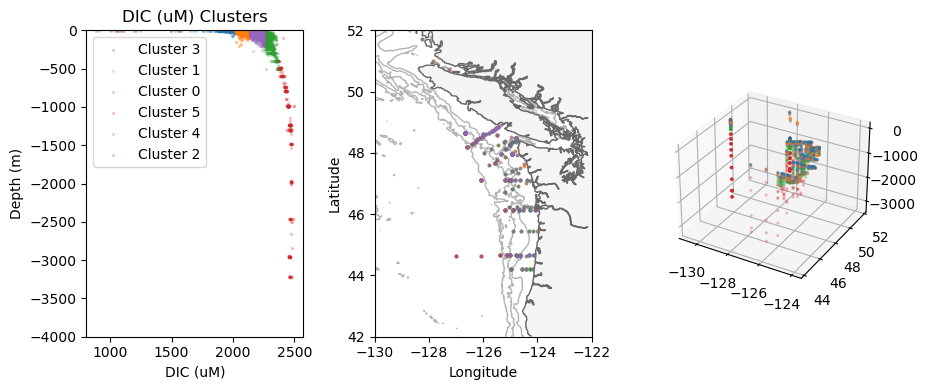

In [76]:
DICcluster = cluster_plot('DIC (uM)')

In [ ]:
# should add plot that shows clusters in time versus depth